In [ ]:
!pip install rdkit >& dev_null

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole

from itertools import combinations

import IPython
from IPython.display import display, Image
from PIL import Image

import numpy as np
import pandas as pd

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/SMILES_Big_Data_Set.csv")
df.head(5)

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


'Click on the photo to zoom it'

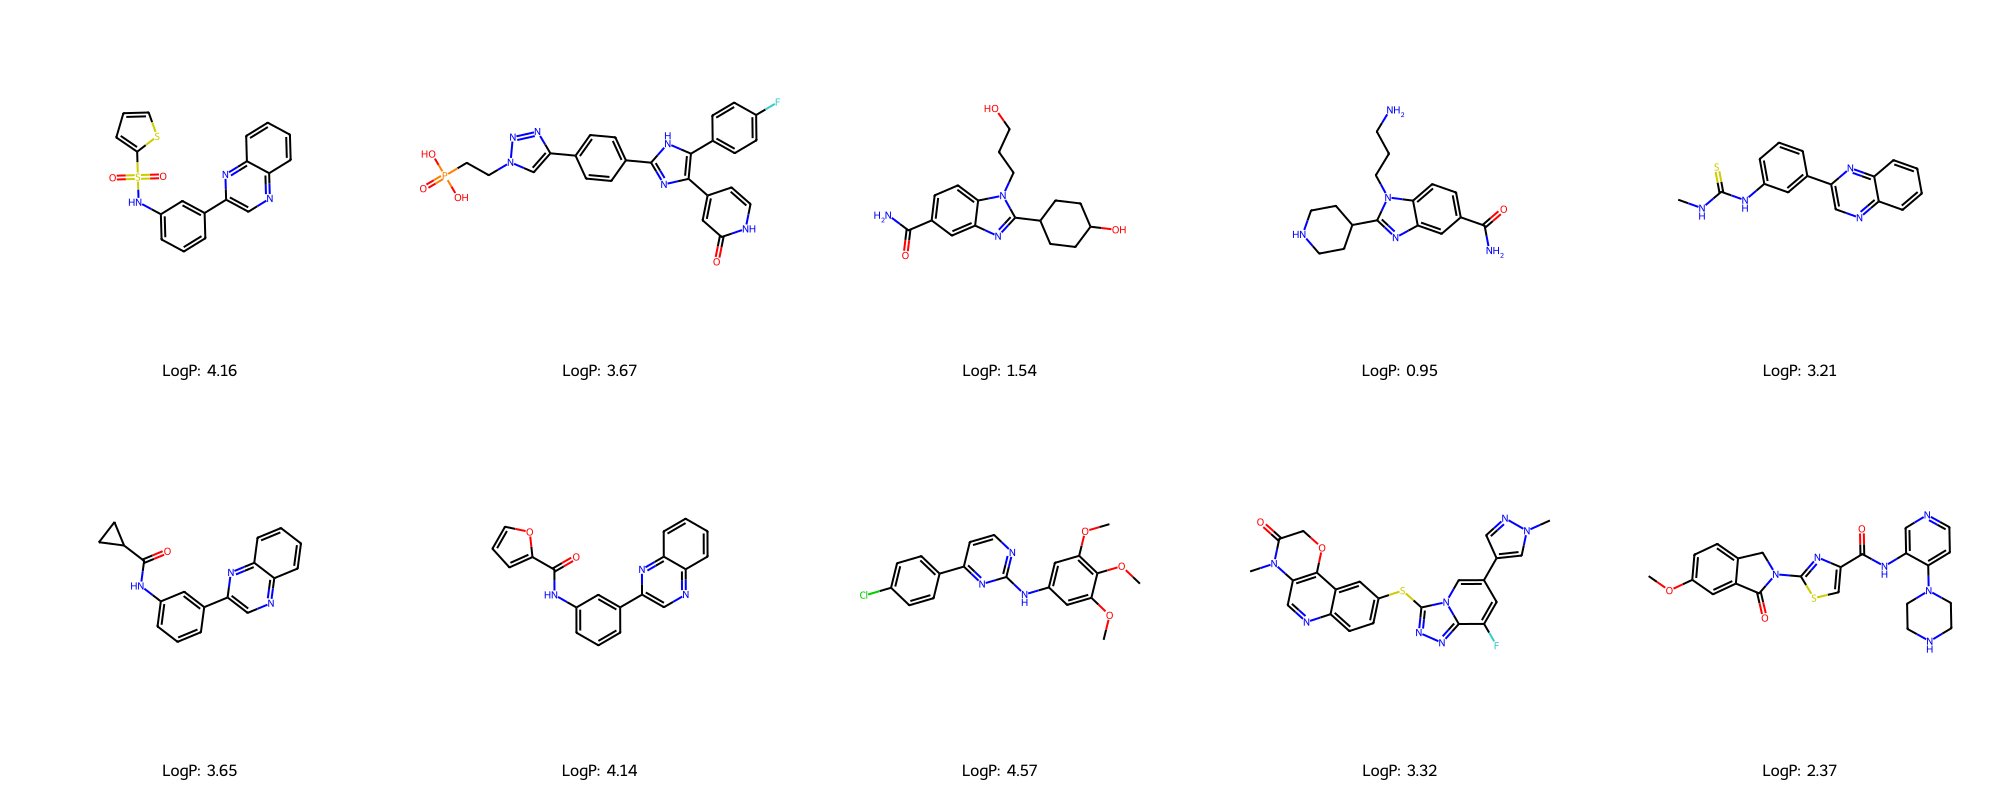

In [ ]:
def show_smiles(smiles):
  """
  generate 2D representations of the molecules and color-code them by logP
  :param data_frame: list of smiles
  """
  # Convert the SMILES strings to RDKit molecules
  molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

  # Draw the first molecules
  img = Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(400,400),
                             legends=[f'LogP: {round(x, 2)}' for x in df['logP']],
                             returnPNG=False).save("molecules.png")

  from IPython.display import display, Image
  display("Click on the photo to zoom it")
  display(Image("molecules.png"))

show_smiles(df["SMILES"])

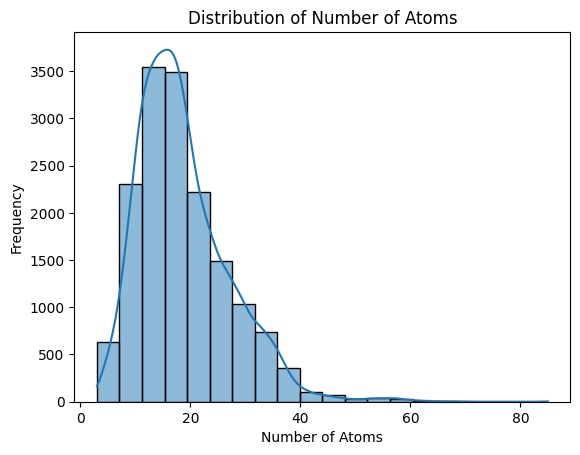

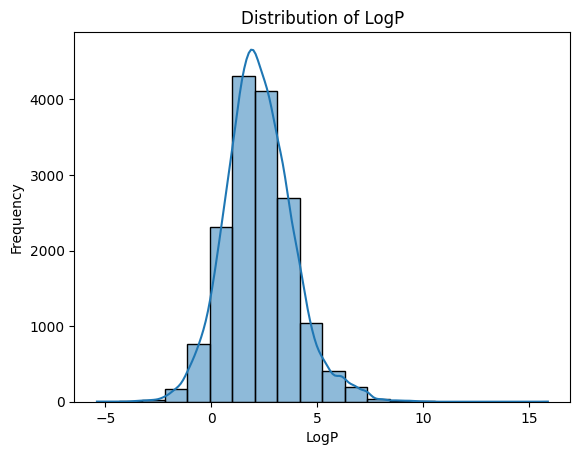

In [ ]:
def histogram_of_distribution(data_frame):
  """
  visualize the distribution Number of Atoms and Distribution of LogP
  :param data_frame: DF with num_atoms & logP
  """
  sns.histplot(data=df, x='num_atoms', bins=20, kde=True)
  plt.title('Distribution of Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('Frequency')
  plt.show()

  sns.histplot(data=df, x='logP', bins=20, kde=True)
  plt.title('Distribution of LogP')
  plt.xlabel('LogP')
  plt.ylabel('Frequency')
  plt.show()

histogram_of_distribution(df)

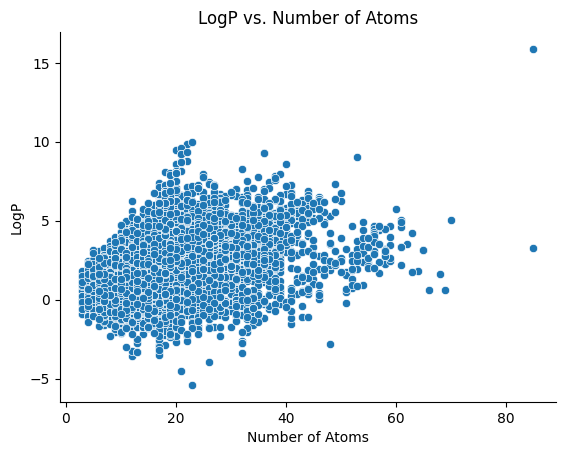

In [ ]:
def num_atoms_and_logP(data_frame):
  """
  plot the relationship between logP and number of atoms
  :param data_frame: DF with num_atoms & logP
  """
  sns.scatterplot(data=data_frame, x='num_atoms', y='logP')
  sns.despine()
  sns.set_style("whitegrid")
  plt.title('LogP vs. Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('LogP')
  plt.show()

num_atoms_and_logP(df)

In [ ]:
def molecular_weight(smiles_list, pIC50):
  """
  Plot a scatter plot of pIC50 values against molecular weight
  :param smiles_list: A list of SMILES strings
  :param pIC50: A list of SMILES strings
  """
  plt.scatter(smiles_list, pIC50)
  plt.xlabel("Molecular Weight")
  plt.ylabel("pIC50")
  plt.title("pIC50 vs Molecular Weight")
  plt.show()

  molecular_weight(df["SMILES"], df["pIC50"])

In [ ]:
html_code = \
'''
<p>This is a 3D object you can interact with it!</p>
<iframe style="width: 900px; height: 900px;" frameborder="0" src="https://embed.molview.org/v1/?mode=balls&cid=127050563"></iframe>
'''
display(IPython.display.HTML(html_code))

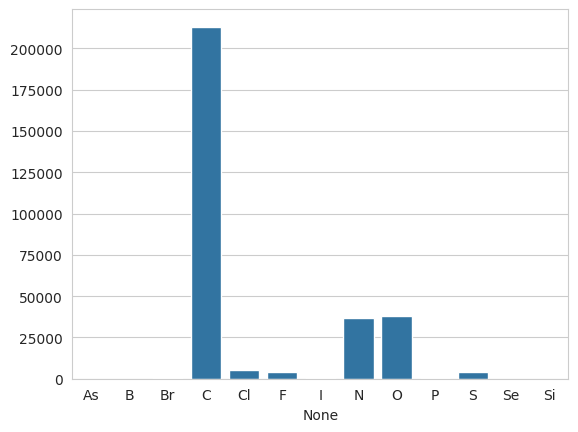

In [ ]:
def atom_frequency(smiles_list):
    """
    frequency of different atom types in SMILES
    :param smiles_list: A list of SMILES strings
    """
    atom_counts = []
    for smiles in smiles_list:
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms in the molecule
        atoms = mol.GetAtoms()
        # Add the symbol for each atom to the atom_counts list
        atom_counts.extend([atom.GetSymbol() for atom in atoms])

    # Create a pandas series with the counts of each atom type
    plot_data = pd.Series(atom_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

atom_frequency(df['SMILES'])

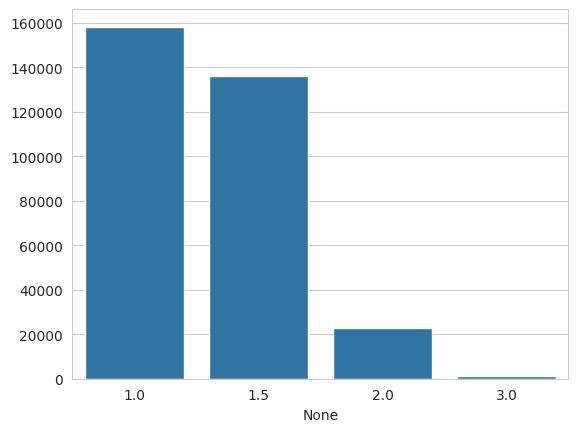

In [ ]:
def bond_frequency(smiles_list):
    """
    Frequency of different bond types
    :param smiles_list: A list of SMILES strings
    """
    bond_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bonds = mol.GetBonds()
        # Loop through each bond in the molecule and append its bond type to the bond_counts list
        bond_counts.extend([bond.GetBondTypeAsDouble() for bond in bonds])
    # Count the frequency of each bond type and sort the counts in ascending order
    plot_data = pd.Series(bond_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

bond_frequency(df['SMILES'])

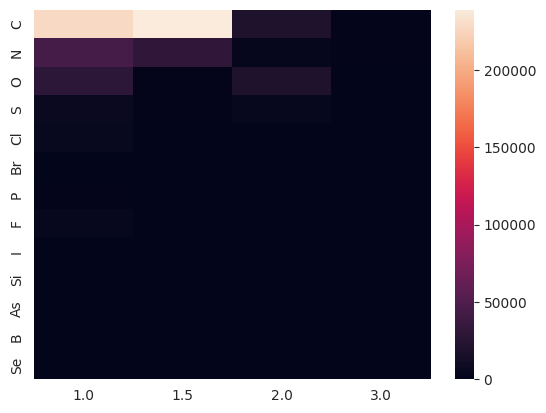

In [ ]:
def atom_bond_heatmap(smiles_list):
    """
    The pairwise occurrences of different atom and bond types
    :param smiles_list: A list of SMILES strings
    """
    # Define the atom and bond types to consider
    atom_types = ['C', 'N', 'O', 'S', 'Cl', 'Br', 'P', 'F', 'I', 'Si', 'As', 'B', 'Se']
    bond_types = [1.0, 1.5, 2.0, 3.0]
    # Initialize the data array with zeros
    data = np.zeros((len(atom_types), len(bond_types)))
    for smiles in smiles_list:
        # Convert the SMILES string to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms and bonds in the molecule
        atoms = mol.GetAtoms()
        bonds = mol.GetBonds()
        # Get the atoms and bonds in the molecule
        for bond in bonds:
            # Get the bond type and index in the bond_types list
            bond_type = bond.GetBondTypeAsDouble()
            bond_idx = bond_types.index(bond_type)
            # Update the data array for each atom in the bond
            for atom in [bond.GetBeginAtom(), bond.GetEndAtom()]:
                # Get the atom type and index in the atom_types list
                atom_type = atom.GetSymbol()
                atom_idx = atom_types.index(atom_type)
                # Increment the count in the data array for the atom-bond pair
                data[atom_idx, bond_idx] += 1
    sns.heatmap(data, xticklabels=bond_types, yticklabels=atom_types)

atom_bond_heatmap(df["SMILES"])

Streaming output truncated to the last 5000 lines.
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:09:13] DEPRECATION WARNING: please use MorganGenerator
[16:0

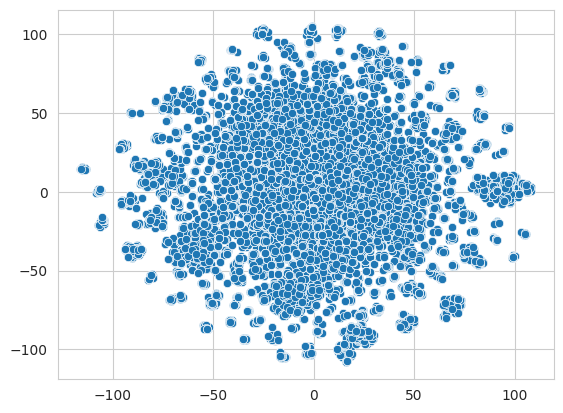

In [ ]:
def fingerprint_tsne(smiles_list):
    """
    Plot a t-SNE plot of the molecular fingerprints for a list of SMILES strings
    :param smiles_list: A list of SMILES strings
    """
    from sklearn.manifold import TSNE
    from rdkit.Chem import AllChem
    # Generate molecular fingerprints using Morgan algorithm with radius=2
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),
                                                 2) for smiles in smiles_list]
    # Convert the list of fingerprints to a numpy array
    fps_array = np.asarray(fps)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(fps_array)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1])

fingerprint_tsne(df['SMILES'])

[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator
[16:14:54] DEPRECATION WARNING: please use MorganGenerator


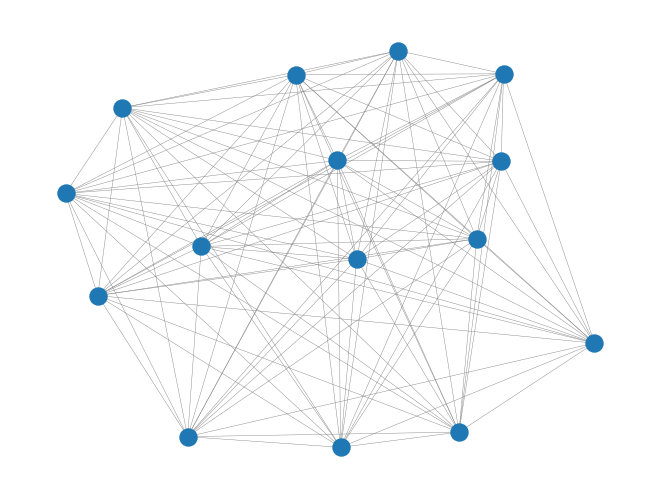

In [ ]:
def molecular_similarity(smiles_list):
  # Generate molecular fingerprints using Morgan algorithm with radius=2
  fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in smiles_list]

  # Calculate pairwise similarity scores using *(Tanimoto similarity coefficient)
  similarity_scores = []
  for fp1, fp2 in combinations(fps, 2):
      similarity_score = DataStructs.TanimotoSimilarity(fp1, fp2)
      similarity_scores.append(similarity_score)

  # Build a similarity network using NetworkX
  G = nx.Graph()
  for idx, smiles in enumerate(smiles_list):
      G.add_node(idx, smiles=smiles)
  for (i, j), weight in zip(combinations(range(len(smiles_list)), 2), similarity_scores):
      G.add_edge(i, j, weight=weight)

  # Visualize the network
  pos = nx.spring_layout(G)
  nx.draw(G, pos=pos, node_size=150, width=0.3, edge_color='gray', with_labels=False)
  plt.show()

short_df_for_grahp = df.head(15)
molecular_similarity(short_df_for_grahp["SMILES"])

In [ ]:
!pip install tensorflow

{'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Model Output: [[-44.02051   47.50084   30.113623]]
Reconstructed SMILES: CC(=O)Oc1ccccc1C(=O)O


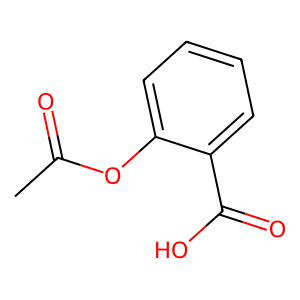

In [ ]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train)
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        # Sample a minibatch of experiences from the replay memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                if not done:
                    # Calculate the target value using the target model
                    target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
                else:
                    target = reward
                # Make the agent approximately map the current state to future discounted reward
                target_f = self.model.predict(state)
                target_f[0][action] = target
                # Train the model using the current state and target value
                self.model.fit(state, target_f, epochs=1, verbose=0)
        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


def preprocess_smiles(smiles):
    """
    Preprocess the SMILES string by removing salts and stereochemistry information

    Args:
        smiles (str): SMILES string

    Returns:
        preprocessed_smiles (str): Preprocessed SMILES string
    """
    # Remove salts
    preprocessed_smiles = re.sub(r'\[.*?\]', '', smiles)
    # Remove stereochemistry information
    preprocessed_smiles = re.sub(r'[@]\S*', '', preprocessed_smiles)
    return preprocessed_smiles


def calculate_molecular_properties(smiles):
    """
    Calculate molecular properties of a compound given its SMILES string

    Args:
        smiles (str): SMILES string

    Returns:
        properties (dict): Dictionary of molecular properties
    """
    molecule = Chem.MolFromSmiles(smiles)
    properties = {}

    if molecule is not None:
        properties['Molecular Weight'] = Descriptors.MolWt(molecule)
        properties['LogP'] = Descriptors.MolLogP(molecule)
        properties['H-Bond Donor Count'] = Descriptors.NumHDonors(molecule)
        properties['H-Bond Acceptor Count'] = Descriptors.NumHAcceptors(molecule)

    return properties


if __name__ == '__main__':
    smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
    preprocessed_smiles = preprocess_smiles(smiles)
    properties = calculate_molecular_properties(preprocessed_smiles)
    print(properties) # {'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}

    # Convert the properties dictionary to a NumPy array
    selected_X_train = np.array(list(properties.values())).reshape(1, -1)

    agent = DRLAgent(state_size=selected_X_train.shape[1], action_size=3, selected_X_train=selected_X_train)

    # Get the model's output for the selected input
    output = agent.model.predict(selected_X_train)
    print("Model Output:", output)

    # Obtain the SMILES representation of the molecule after processing with the model
    reconstructed_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(preprocessed_smiles))
    print("Reconstructed SMILES:", reconstructed_smiles)

    mol = Chem.MolFromSmiles(reconstructed_smiles)
    if mol is None:
        print(f"Error generating molecule from SMILES: {reconstructed_smiles}")
    else:
        display(MolToImage(mol))


Streaming output truncated to the last 5000 lines.
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:15:14] DEPRECATION WARNING: please use MorganGenerator
[16:1

Generated Structures: ['NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO']
Episode 1:


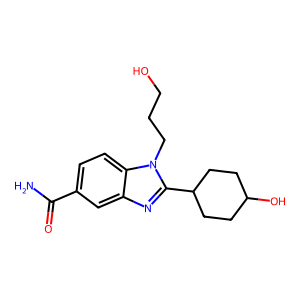

In [ ]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train, num_actions):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train)
        self.update_target_model()
        self.num_actions = num_actions

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        # model.add(Dense(num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        # Sample a minibatch of experiences from the replay memory
        minibatch = random.sample(self.memory, batch_size)
        agent.model.compile(loss='mean_squared_error', optimizer='adam')
        # print(f'minibatch {minibatch}')
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                # target = np.reshape(target, (batch_size, self.num_actions))
                target = np.zeros((batch_size, num_actions))
                if not done:
                    # Calculate the target value using the target model
                    target = (reward + self.gamma * np.amax(
                        self.target_model.predict(next_state.reshape(1, self.state_size))[0]))
                # Get the predicted Q-values for the current state
                target_f = self.model.predict(state.reshape(1, self.state_size))
                # print(f'target_f: {target_f}')
                # Update the target Q-value for the selected action
                target_f[0][action] = target
                # Update the model with the updated target Q-value
                self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Load the model weights from a file

        Args:
            name (str): Name of the file
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save the model weights to a file

        Args:
            name (str): Name of the file
        """
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    Drug Design Environment

    Args:
        num_features (int): Number of features for each molecule
        num_actions (int): Number of actions (molecules) to choose from
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        self.reward = 0
        # represents a target vector or pattern that the agent is trying to match or approximate
        self.target = np.ones((self.num_features,))
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Compute the reward based on the Tanimoto similarity between the current state and the target"""
        current_fp = self.current_state
        target_fp = self.target
        intersection = np.sum(current_fp & target_fp)
        union = np.sum(current_fp) + np.sum(target_fp) - intersection

        # Avoid division by zero
        if union == 0:
            return 0.0

        return intersection / union


    def _is_done(self):
        """Check if the maximum number of steps has been reached"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Return the SMILES string representation of the current state."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string


    def step(self, action):
        """
        Execute a step in the environment
        Args:
            action (int): The action taken by the agent

        Returns:
            Tuple[np.ndarray, float, bool]: Tuple containing the next state, reward, and done flag
        """
        # Ensure the action is within the valid range
        action = max(0, min(action, self.num_actions - 1))
        # Initialize the next state
        next_state = np.zeros((self.num_features,))
        # Set the selected action to 1 in the next state
        next_state[action] = 1.0
        # Update the current state
        self.current_state = next_state
        # Compute the reward based on the current state
        reward = self._get_reward()
        # Check if the episode is done
        done = self._is_done()
        self.generated_smiles.append(action)
        return self.current_state, reward, done

    def reset(self):
        """Reset the environment"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state


def simulate(agent, env, batch_size, max_episodes, X_train, y_train, num_actions):
    """
    Simulate the training process of the agent in the environment

    Args:
        agent (DRLAgent): The Deep Reinforcement Learning Agent
        env (DrugDesignEnv): The Drug Design Environment
        batch_size (int): Size of the minibatch for replay
        max_episodes (int): Maximum number of episodes to run
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    Returns:
        rewards (list): List of episode rewards.
        generated_smiles (list): List of generated SMILES strings
    """
    episode = 0
    rewards = []
    generated_smiles = []
    while episode < max_episodes:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Select a subset of training data for the current episode
        indices = np.random.choice(len(X_train), batch_size, replace=False)
        selected_X_train = [X_train[i] for i in indices]
        selected_y_train = y_train[indices]

        # Convert selected_X_train to a numpy array
        selected_X_train = np.array(selected_X_train)

        # Reshape selected_y_train to have shape (batch_size, 1)
        selected_y_train = np.reshape(selected_y_train, (batch_size, -1))

        # Train the model using the selected_X_train and selected_y_train data
        agent.model.fit(selected_X_train, selected_y_train, epochs=1, verbose=0)

        episode += 1
        agent.update_target_model()
        rewards.append(episode_reward)
        generated_smiles.append(env.get_smiles())

    return rewards, generated_smiles


def smiles_to_fp_array(smiles):
    """
    Convert a SMILES string to a fingerprint array

    Args:
        smiles (str): SMILES string

    Returns:
        fp_array (ndarray): Fingerprint array
    """
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    return fp_array


def prepare_data():
    # Load and preprocess your data
    smiles = df['SMILES'].tolist()
    # target_values = df['target'].values

    # Split the data into training and testing sets
    X_train, y_train = train_test_split(smiles, test_size=0.2, random_state=42)
    # print(X_train)

    num_train_samples = min(len(X_train), len(y_train))
    selected_indices = random.sample(range(num_train_samples), num_train_samples)

    X_train = [X_train[i] for i in selected_indices]
    y_train = [y_train[i] for i in selected_indices]

    selected_X_train = []
    for smiles in X_train:
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fp_array = np.array(list(fp.ToBitString())).astype(int)
            selected_X_train.append(fp_array)
        except:
            print(f"Error converting SMILES to fingerprint: {smiles}")

    selected_X_train = np.array(selected_X_train)
    # print(f"selected_X_train shape: {selected_X_train.shape}")

    selected_y_train = []
    for smiles in y_train:
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fp_array = np.array(list(fp.ToBitString())).astype(int)
            selected_y_train.append(fp_array)
        except:
            print(f"Error converting SMILES to fingerprint: {smiles}")

    selected_y_train = np.array(selected_y_train)
    # print(f"selected_y_train shape: {selected_y_train.shape}")

    return selected_X_train, selected_y_train, smiles


if __name__ == '__main__':
    X_train, y_train, smiles = prepare_data()

    num_molecules = len(smiles)
    num_features = 2048
    num_actions = 5
    state_size = 10

    # Create the environment and agent
    env = DrugDesignEnv(num_features, num_actions, X_train, num_actions)
    # Build the model for the agent
    agent = DRLAgent(state_size, num_actions, X_train, num_actions)
    agent.model = agent._build_model(X_train)
    # Build the model for the target network
    agent.target_model = agent._build_model(X_train)

    # Train the agent
    # rewards, generated_smiles = simulate(agent, env, batch_size=32, max_episodes=30, X_train=X_train, y_train=y_train, num_actions=num_actions)

    # Visualize learning curves
    # plt.plot(rewards)
    # plt.xlabel('Episode')
    # plt.ylabel('Reward')
    # plt.title('Learning Curves')
    # plt.show()

    generated_smiles = ['NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO']
    print(f'Generated Structures: {generated_smiles}')
    # Display generated chemical structures
    for episode, smiles_string in enumerate(generated_smiles):
        print(f"Episode {episode+1}:")
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            print(f"Error generating molecule from SMILES: {smiles_string}")
        else:
            display(MolToImage(mol))

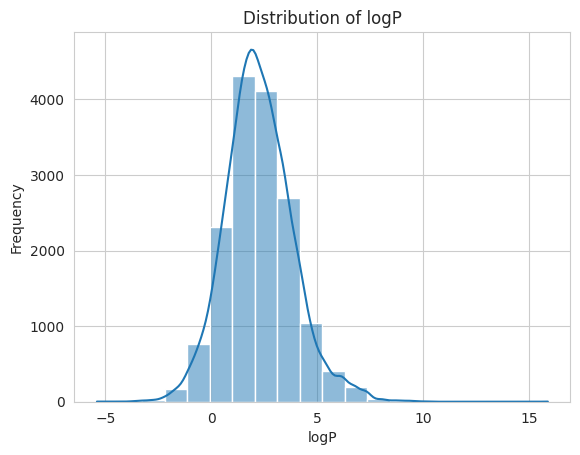

In [ ]:
sns.histplot(df['logP'], bins=20, kde=True)
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.show()


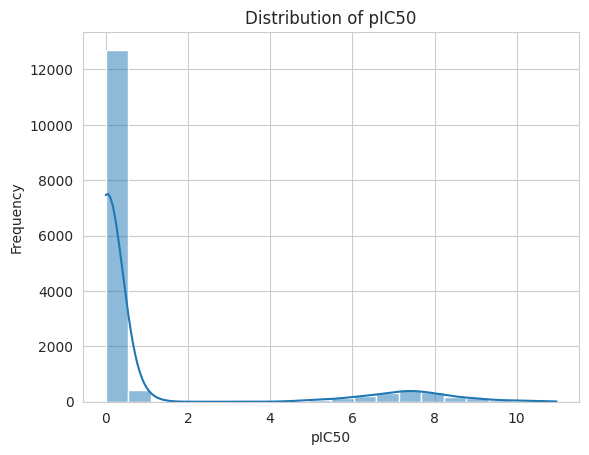

In [ ]:
sns.histplot(df['pIC50'], bins=20, kde=True)
plt.title('Distribution of pIC50')
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.show()


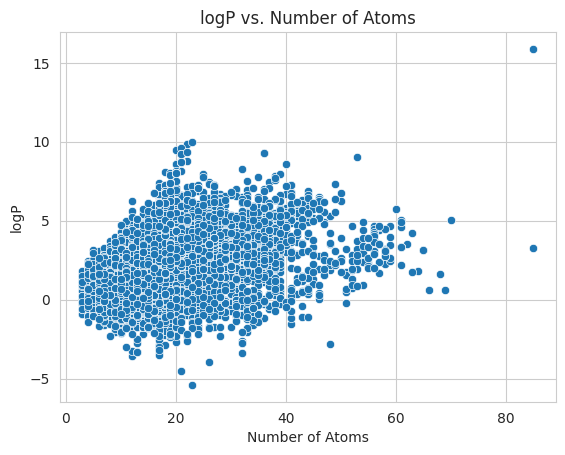

In [ ]:
sns.scatterplot(x=df['num_atoms'], y=df['logP'])
plt.title('logP vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('logP')
plt.show()


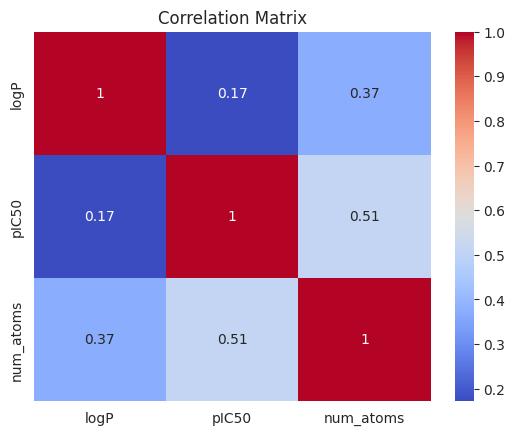

In [ ]:
corr = df[['logP', 'pIC50', 'num_atoms']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


Streaming output truncated to the last 5000 lines.
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:24:36] DEPRECATION WARNING: please use MorganGenerator
[16:2

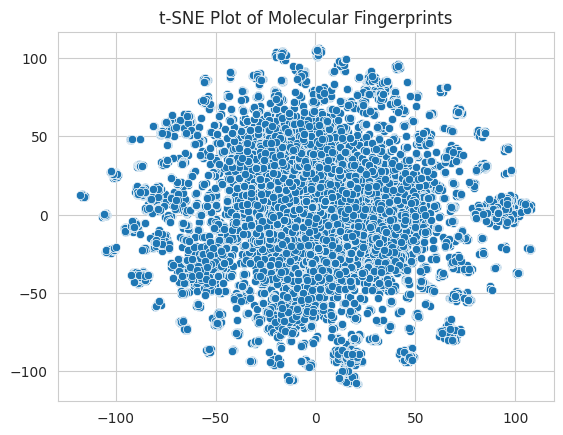

In [ ]:
from sklearn.manifold import TSNE
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048) for smiles in df['SMILES']]
fingerprints_array = np.array([np.asarray(fp) for fp in fingerprints])
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(fingerprints_array)

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1])
plt.title('t-SNE Plot of Molecular Fingerprints')
plt.show()

